In [25]:
import pandas as pd 
import numpy as np
import math 
from matplotlib import pyplot

In [8]:
# Function: calculate MAD saccade
def at_mad(angular_vel, th_0=200):
    # defines the saccade threshold (code from Ashima)
    threshs = []
    while True:
        # take th_0
        threshs.append(th_0)
        # get all angles smaller than this
        angular_vel = angular_vel[angular_vel < th_0]

        # MAD:
        # take the median of all angles smaller than th_0
        median = np.median(angular_vel)
        # substract the median value
        diff = np.sqrt((angular_vel - median) ** 2)
        # get the median of these values
        med_abs_deviation = np.median(diff)

        # calcualte the next threshold with the median
        # 1.486 used when assuming a normal distribution
        th_1 = median + 3 * 1.486 * med_abs_deviation
        # if the thresholds are too different, redo the while loop
        if abs(th_0 - th_1) > 1:
            th_0 = th_1
        # else, set the final threshold to the current one, break the while loop and return values
        else:
            saccade_thresh = th_1
            threshs.append(saccade_thresh)
            break
    return saccade_thresh, threshs

In [34]:
One_participant = pd.read_csv("/Volumes/SSD/00_Data_Processing/Pre_processed/04_Interpolated/0479_2.csv" )

In [3]:
Complete = pd.read_csv("/Volumes/SSD/00_Data_Processing/Pre_processed/Complete_Data_AngularV.cvs")

In [35]:
One= Complete[(Complete.SubjectID == 479) & (Complete.Session == 2)].copy()

In [113]:
%%timeit
######## Debbies Algorithm ########

for_eye = One_participant.copy()
time = for_eye["timeStampDataPointEnd"].tolist()

## Calculate Angular velocities
# get individual coordinates
subj = list(zip( for_eye["eyePositionCombinedWorld.x"],for_eye["eyePositionCombinedWorld.y"],for_eye["eyePositionCombinedWorld.z"]))
hpoo = list(zip(for_eye["hitPointOnObject_x"], for_eye["hitPointOnObject_y"],for_eye["hitPointOnObject_z"]))
# v_gaze_vec: get difference in hpoo
v_gaze_vec = list(zip(for_eye["hitPointOnObject_x"].diff(), for_eye["hitPointOnObject_y"].diff(),for_eye["hitPointOnObject_z"].diff()))
# get difference in time:
ts = for_eye["timeStampDataPointEnd"].diff().tolist()
# gaze_vec(t) is a unit vector in the direction of the gaze (eye+head) in world coordinates
g_vec = list(np.subtract(hpoo, subj))
gaze_vec = [np.array(v) / np.linalg.norm(np.array(v)) for v in g_vec]
# v_gaze_inplane: is a scalar indicating the velocity in world coordinates at the location that is gazed at orthogonal to the gaze axis.
z1 = [np.dot(v_gaze_vec_i, gaze_vec_i) for v_gaze_vec_i, gaze_vec_i in zip(v_gaze_vec, gaze_vec)]
# z = (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))
z = [z1[element] * np.array(gaze_vec[element]) for element in range(len(z1))]
# ||v_gaze_vec(t) - z||
v_gaze_inplane = np.linalg.norm(np.array(v_gaze_vec) - z, axis=-1)
#Eucledian distance between eye coordinates and hit on object
sub_hpoo = np.linalg.norm(np.array(subj) - np.array(hpoo), axis=-1)
# arctan2(v_gaze_inplane, sub_hpoo)
w_gaze = np.arctan2(v_gaze_inplane, sub_hpoo).tolist()
# Turn angle of radians into degrees over seconds 
w_gaze = [(w / ts[idx] * 180 / math.pi) for idx, w in enumerate(w_gaze)]
# save df
for_eye["combined_vel"] = w_gaze

### 10 second for threshold calculation starts here

int_len = 10  # number of seconds of the interval
time = for_eye["timeStampDataPointEnd"].values
start = [time[0]]
end = []
start_idx = [0]
end_idx = []
for t, ti in enumerate(time[1:], start=1):
    if ti - start[-1] > int_len:
        end.append(time[t - 1])
        end_idx.append(t - 1)
        start.append(ti)
        start_idx.append(t)
# add the last timepoint to end
end.append(time[-1])
end_idx.append(len(time))

# save it as new df
int_data = pd.DataFrame({
    "start": start,
    "end": end,
    "start_idx": start_idx,
    "end_idx": end_idx
})

combined_vel = for_eye["combined_vel"]

# to add the final thresholds to for each segement
scct = []
for s, srt in enumerate(int_data["start"].values):
    # get the slice of the combined velocity
    angular_vel = combined_vel[start_idx[s] : end_idx[s]]
    # use the at_mad function to caluclate the threshold
    saccade_th, thres = at_mad(angular_vel)
    if np.isnan(saccade_th):
        scct.append(thres[0])
    else:
        # add it to scct
        scct.append(saccade_th)

# add it to int_data and save
int_data["thresh"] = scct

ranges = list(zip(int_data.start_idx, int_data.end_idx))    
# go through all time intervals repeat the threshold as often as the time interval is long
for i, (lower, upper) in enumerate(ranges):
    for_eye.loc[lower:upper,"thresh"]  = int_data["thresh"][i]

# eye-tracking
thres = int_data["thresh"].values
combined_vel = for_eye["combined_vel"].values

# define list where the fixations will be added too
is_fix = [np.nan] * len(combined_vel)
start = int_data["start_idx"].tolist()
end = int_data["end_idx"].tolist()

# eye-tracking
thres = int_data["thresh"].tolist()
combined_vel = for_eye["combined_vel"].tolist()


for i in range(len(start)):
    av = combined_vel[start[i] : end[i]]
    # go through combined velocity and save all that are bigger than the threshold
    fix = [ti if ti < thres[i] else np.nan for ti in av]
    is_fix[start[i] : end[i]] = fix
for_eye["isFix"] = is_fix


3.56 s ± 62.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [117]:
# eye-tracking
thres = int_data["thresh"].values
combined_vel = for_eye["combined_vel"].values

# define list where the fixations will be added too
is_fix = [np.nan] * len(combined_vel)
start = int_data["start_idx"].tolist()
end = int_data["end_idx"].tolist()

# eye-tracking
thres = int_data["thresh"].tolist()
combined_vel = for_eye["combined_vel"].tolist()
for i in range(len(start)):
    av = combined_vel[start[i] : end[i]]

In [120]:
len(start)

180

In [ ]:

for i, (lower, upper) in enumerate(ranges):
    for_eye.loc[lower:upper,"is-FIXI"]  = int_data["thresh"][i]

In [ ]:
# eye-tracking
thres = int_data["thresh"].values
combined_vel = for_eye["combined_vel"].values

# define list where the fixations will be added too
is_fix = [np.nan] * len(combined_vel)
start = int_data["start_idx"].tolist()
end = int_data["end_idx"].tolist()

# eye-tracking
thres = int_data["thresh"].tolist()
combined_vel = for_eye["combined_vel"].tolist()


for i in range(len(start)):
    av = combined_vel[start[i] : end[i]]
    # go through combined velocity and save all that are bigger than the threshold
    fix = [ti if ti < thres[i] else np.nan for ti in av]
    is_fix[start[i] : end[i]] = fix
for_eye["isFix"] = is_fix

In [116]:
%%timeit

######## Debbies Algorithm ########

for_eye = One_participant.copy()

time = for_eye["timeStampDataPointEnd"].tolist()
# get individual coordinates
subj = list(zip( for_eye["eyePositionCombinedWorld.x"],for_eye["eyePositionCombinedWorld.y"],for_eye["eyePositionCombinedWorld.z"]))
hpoo = list(zip(for_eye["hitPointOnObject_x"], for_eye["hitPointOnObject_y"],for_eye["hitPointOnObject_z"]))

# v_gaze_vec: get difference in hpoo
v_vX = for_eye["hitPointOnObject_x"].diff()
v_vY = for_eye["hitPointOnObject_y"].diff()
v_vZ = for_eye["hitPointOnObject_z"].diff()


# get difference in time:
ts = pd.DataFrame(time).apply(lambda x: x.diff())[0].tolist()
v_gaze_vec = list(zip(v_vX, v_vY, v_vZ))

# gaze_vec(t) is a unit vector in the direction of the gaze (eye+head) in world coordinates
g_vec = [np.array(hpoo[v] - np.array(subj[v])) for v in range(len(subj))]
gaze_vec = [np.array(v) / np.linalg.norm(np.array(v)) for v in g_vec]


# v_gaze_inplane: is a scalar indicating the velocity in world coordinates at the location that is gazed at orthogonal to the gaze axis.
# v_gaze_inplane(t) = ||v_gaze_vec(t) - (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))||:
# z1 = (<v_gaze_vec(t), gaze_vec(t)>)
z1 = [np.array(v_gaze_vec[t]).dot(np.array(gaze_vec[t]))
        for t in range(len(v_vX))]

# z = (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))
z = [z1[t] * np.array(gaze_vec[t]) for t in range(len(v_vX))]

# ||v_gaze_vec(t) - z||
v_gaze_inplane = [np.linalg.norm((np.array(v_gaze_vec[t]) - z[t]).tolist())
        for t in range(len(v_gaze_vec))
                 ]
# w_gaze(t) = arctan2(||subject_vec(t) - hpoo_vec(t)||, v_gaze_inplane)

# sub_hpoo = ||subject_vec(t) - hpoo_vec(t)||
sub_hpoo = [np.linalg.norm(np.array(subj[t]) - np.array(hpoo[t]))
        for t in range(len(hpoo))]

# arctan2(v_gaze_inplane, sub_hpoo)
w_gaze = np.arctan2(v_gaze_inplane, sub_hpoo).tolist()

# turn angle of radians into degrees
#w_gaze = [np.rad2deg(value) for value in w_gaze]
w_gaze = [(w / ts[idx] * 180 / math.pi) for idx, w in enumerate(w_gaze)]
# save df
for_eye["combined_vel"] = w_gaze
### 10 second starts here 
int_len = 10  # number of seconds of the interval

time = for_eye["timeStampDataPointEnd"].tolist()
start = []
end = []
start_idx = []
end_idx = []
for t, ti in enumerate(time):
    if ti == time[0]:
        start.append(ti)
        start_idx.append(t)
    if ti - start[-1] > int_len:
        # if the current timepoint is more than int_len away from start, set it to new start
        start.append(ti)
        start_idx.append(t)
        # and set end to the timepoint before that
        end.append(time[t - 1])
        end_idx.append(t - 1)
# add the last timepoint to end
# (there is a very slim chance that the last start and end are the same timepoint --> might cause errors)
end.append(time[-1])
end_idx.append(len(time))

# save it as new df
int_data = list(zip(start, end, start_idx, end_idx))
int_data = pd.DataFrame(
    int_data, columns=["start", "end", "start_idx", "end_idx"]
)

combined_vel = for_eye["combined_vel"]

# to shorten the slicing in the next for loop
start_idx = int_data["start_idx"].tolist()
end_idx = int_data["end_idx"].tolist()

# to add the final thresholds to for each segement
scct = []
for s, srt in enumerate(int_data["start"].tolist()):
    # get the slice of the combined velocity
    angular_vel = combined_vel[start_idx[s] : end_idx[s]]
    # use the at_mad function to caluclate the threshold
    saccade_th, thres = at_mad(angular_vel)
    if np.isnan(saccade_th):
        scct.append(thres[0])
    else:
        # add it to scct
        scct.append(saccade_th)

# add it to int_data and save
int_data["thresh"] = scct
int_data = pd.DataFrame(int_data)
time = for_eye.timeStampDataPointEnd.tolist()
start_idx = int_data["start_idx"].tolist()
end_idx = int_data["end_idx"].tolist()
thr = int_data["thresh"].tolist()

# go through all time intervals
thresh = [0.0] * len(time)
for s, srt in enumerate(int_data["start"].tolist()):
    # repeat the threshold as often as the time interval is long
    thresh = (
        thresh[: start_idx[s]]
        + [thr[s]] * len(time[start_idx[s] : end_idx[s]])
        + thresh[end_idx[s]:]
    )

# add the two lists (ht & et) to for_eye df
for_eye["thresh"] = thresh

# save for_eye df
for_eye = pd.DataFrame(for_eye)

start = int_data["start_idx"].tolist()
end = int_data["end_idx"].tolist()

# eye-tracking
thres = int_data["thresh"].tolist()
combined_vel = for_eye["combined_vel"].tolist()

# define list where the fixations will be added too
is_fix = [np.nan] * len(combined_vel)

for i in range(len(start)):
    av = combined_vel[start[i] : end[i]]
    # go through combined velocity and save all that are bigger than the threshold
    fix = [ti if ti < thres[i] else np.nan for ti in av]
    is_fix[start[i] : end[i]] = fix

# save
for_eye["isFix"] = is_fix


6.41 s ± 306 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [109]:
ranges = list(zip(int_data.start_idx, int_data.end_idx))
#Replace the invalid event with the mode of 20 events prior
for i, (lower, upper) in enumerate(ranges):
    for_eye.loc[lower:upper,"THRESHI"]  = int_data["thresh"][i]

In [110]:
for_eye.head(200)

,Unnamed: 0,index,Unnamed: 0.1,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,combinedGazeValidityBitmask,eyePositionCombinedWorld.x,eyePositionCombinedWorld.y,...,Face_Hits,Continuous_Time,Time_Shift,Bitmask_flag,Interpolated_collider,combined_vel,thresh,isFix,Threshi,THRESHI
0,0,0,6214920,479,2,1,1.653045e+09,3,-59.108826,2.260380,...,Not_Agent,0.0,0.000496,No_change,Building_161,NaN,76.520677,NaN,NaN,76.520677
1,1,1,6214921,479,2,1,1.653045e+09,3,-59.116348,2.260123,...,Not_Agent,0.0,0.008432,No_change,Building_161,112.687307,76.520677,NaN,NaN,76.520677
2,2,2,6214922,479,2,1,1.653045e+09,3,-59.116287,2.260142,...,Not_Agent,0.0,0.006447,No_change,Building_161,1.023749,76.520677,1.023749,NaN,76.520677
3,3,3,6214923,479,2,1,1.653045e+09,3,-59.134151,2.259476,...,Not_Agent,0.0,0.011905,No_change,Building_161,43.790524,76.520677,43.790524,NaN,76.520677
4,4,4,6214925,479,2,1,1.653045e+09,3,-59.138229,2.259230,...,Not_Agent,0.0,0.011408,No_change,Building_161,53.432133,76.520677,53.432133,NaN,76.520677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,195,6215280,479,2,1,1.653045e+09,0,-59.133492,2.259826,...,Not_Agent,0.0,0.022320,53.44474029541016,road_base_network.004,NaN,76.520677,NaN,NaN,76.520677
196,196,196,6215282,479,2,1,1.653045e+09,0,-59.133827,2.259660,...,Not_Agent,0.0,0.010912,53.44474029541016,road_base_network.004,NaN,76.520677,NaN,NaN,76.520677
197,197,197,6215283,479,2,1,1.653045e+09,3,-59.162273,2.257645,...,Not_Agent,0.0,0.010912,Invalid_Section_Ends,road_base_network.004,NaN,76.520677,NaN,NaN,76.520677
198,198,198,6215284,479,2,1,1.653045e+09,3,-59.162540,2.256933,...,Not_Agent,0.0,0.011409,No_change,TaskBuilding_35,839.159344,76.520677,NaN,NaN,76.520677


In [98]:
int_data.start

0      1.653045e+09
1      1.653045e+09
2      1.653045e+09
3      1.653045e+09
4      1.653045e+09
           ...     
175    1.653048e+09
176    1.653048e+09
177    1.653048e+09
178    1.653048e+09
179    1.653048e+09
Name: start, Length: 180, dtype: float64

In [96]:
for_eye.head()

,Unnamed: 0,index,Unnamed: 0.1,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,combinedGazeValidityBitmask,eyePositionCombinedWorld.x,eyePositionCombinedWorld.y,...,Collider_stays,Face_Hits,Continuous_Time,Time_Shift,Bitmask_flag,Interpolated_collider,combined_vel,thresh,isFix,Threshi
0,0,0,6214920,479,2,1,1.653045e+09,3,-59.108826,2.260380,...,False,Not_Agent,0.0,0.000496,No_change,Building_161,NaN,76.520677,NaN,NaN
1,1,1,6214921,479,2,1,1.653045e+09,3,-59.116348,2.260123,...,False,Not_Agent,0.0,0.008432,No_change,Building_161,112.687307,76.520677,NaN,NaN
2,2,2,6214922,479,2,1,1.653045e+09,3,-59.116287,2.260142,...,False,Not_Agent,0.0,0.006447,No_change,Building_161,1.023749,76.520677,1.023749,NaN
3,3,3,6214923,479,2,1,1.653045e+09,3,-59.134151,2.259476,...,False,Not_Agent,0.0,0.011905,No_change,Building_161,43.790524,76.520677,43.790524,NaN
4,4,4,6214925,479,2,1,1.653045e+09,3,-59.138229,2.259230,...,False,Not_Agent,0.0,0.011408,No_change,Building_161,53.432133,76.520677,53.432133,NaN


In [37]:
New = for_eye["combined_vel"]

In [47]:
for_eye.columns

Index(['Unnamed: 0', 'index', 'Unnamed: 0.1', 'SubjectID', 'Session',
       'SessionSubsection', 'timeStampDataPointEnd',
       'combinedGazeValidityBitmask', 'eyePositionCombinedWorld.x',
       'eyePositionCombinedWorld.y', 'eyePositionCombinedWorld.z',
       'eyeDirectionCombinedWorld.y', 'eyeDirectionCombinedWorld.z',
       'eyeDirectionCombinedLocal.x', 'eyeDirectionCombinedLocal.y',
       'eyeDirectionCombinedLocal.z', 'playerBodyPosition.x',
       'playerBodyPosition.y', 'playerBodyPosition.z', 'bodyTrackerRotation.x',
       'bodyTrackerRotation.y', 'bodyTrackerRotation.z', 'hitColliderType',
       'hitObjectColliderName', 'ordinalOfHit', 'hitPointOnObject_x',
       'hitPointOnObject_y', 'hitPointOnObject_z', 'Eucledian_distance',
       'Collider_Categorical', 'Previous_Euclidean_value', 'Collider_stays',
       'Face_Hits', 'Continuous_Time', 'Time_Shift', 'Bitmask_flag',
       'Interpolated_collider', 'combined_vel'],
      dtype='object')

In [38]:
Old = One["combined_vel"]

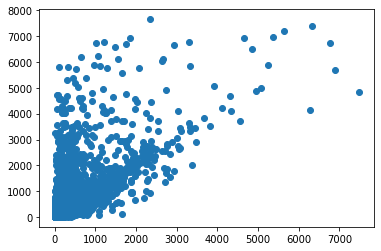

In [39]:
pyplot.scatter(New, Old)

In [40]:
from scipy.stats import spearmanr
corr, _ = spearmanr(New, Old, nan_policy='omit')
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: 0.927


In [41]:
### 10 second starts here 
int_len = 10  # number of seconds of the interval
time = for_eye["timeStampDataPointEnd"].values
start = []
end = []
start_idx = []
end_idx = []
for t, ti in enumerate(time):
    if ti == time[0]:
        start.append(ti)
        start_idx.append(t)
    if ti - start[-1] > int_len:
        # if the current timepoint is more than int_len away from start, set it to new start
        start.append(ti)
        start_idx.append(t)
        # and set end to the timepoint before that
        end.append(time[t - 1])
        end_idx.append(t - 1)
# add the last timepoint to end
# (there is a very slim chance that the last start and end are the same timepoint --> might cause errors)
end.append(time[-1])
end_idx.append(len(time))

In [60]:
for_eye.Continuous_Time.head(20)

0     0.000
1     0.000
2     0.000
3     0.000
4     0.001
5     0.001
6     0.001
7     0.002
8     0.002
9     0.002
10    0.002
11    0.002
12    0.003
13    0.003
14    0.003
15    0.004
16    0.004
17    0.004
18    0.005
19    0.005
Name: Continuous_Time, dtype: float64

In [76]:
import datetime
for_eye["datetime_objects"] = [datetime.datetime.utcfromtimestamp(timestamp) for timestamp in for_eye["timeStampDataPointEnd"]]
df_resampled = for_eye.resample('10S', on='datetime_objects').first()
# Get the index of the resampled DataFrame
resampled_index = df_resampled.index

In [87]:
df_resampled["saccade_thi"], df_resampled["thresi"] = for_eye["combined_vel"].rolling('10s').apply(at_mad)

ValueError: window must be an integer

In [82]:
df_resampled["saccade_thi"], df_resampled["thresi"] = at_mad(df_resampled.combined_vel)

ValueError: Length of values (5) does not match length of index (263)

In [80]:
saccade_thi

IndexError: invalid index to scalar variable.

In [78]:
df_resampled.columns

Index(['Unnamed: 0', 'index', 'Unnamed: 0.1', 'SubjectID', 'Session',
       'SessionSubsection', 'timeStampDataPointEnd',
       'combinedGazeValidityBitmask', 'eyePositionCombinedWorld.x',
       'eyePositionCombinedWorld.y', 'eyePositionCombinedWorld.z',
       'eyeDirectionCombinedWorld.y', 'eyeDirectionCombinedWorld.z',
       'eyeDirectionCombinedLocal.x', 'eyeDirectionCombinedLocal.y',
       'eyeDirectionCombinedLocal.z', 'playerBodyPosition.x',
       'playerBodyPosition.y', 'playerBodyPosition.z', 'bodyTrackerRotation.x',
       'bodyTrackerRotation.y', 'bodyTrackerRotation.z', 'hitColliderType',
       'hitObjectColliderName', 'ordinalOfHit', 'hitPointOnObject_x',
       'hitPointOnObject_y', 'hitPointOnObject_z', 'Eucledian_distance',
       'Collider_Categorical', 'Previous_Euclidean_value', 'Collider_stays',
       'Face_Hits', 'Continuous_Time', 'Time_Shift', 'Bitmask_flag',
       'Interpolated_collider', 'combined_vel', 'thresh', 'isFix',
       'datetime_objects'],
  

In [72]:
len(df_resampled)

263

In [66]:
import datetime
for_eye["datetime_objects"] = [datetime.datetime.utcfromtimestamp(timestamp) for timestamp in for_eye["timeStampDataPointEnd"]]
datetime.datetime.utcfromtimestamp(for_eye.loc[1,"timeStampDataPointEnd"])

datetime.datetime(2022, 5, 20, 11, 17, 2, 206557)

In [58]:
for_eye["time-time"]

0   1970-01-01 00:00:01.653045422
1   1970-01-01 00:00:01.653045422
2   1970-01-01 00:00:01.653045422
3   1970-01-01 00:00:01.653045422
4   1970-01-01 00:00:01.653045422
Name: time-time, dtype: datetime64[ns]

In [56]:
for_eye["Continuous_Time"].describe()

count    115535.000000
mean         21.084083
std          14.175100
min           0.000000
25%           7.556000
50%          19.225000
75%          36.360000
max          43.758000
Name: Continuous_Time, dtype: float64

In [11]:
# to shorten the slicing in the next for loop
start_idx = int_data["start_idx"].values
end_idx = int_data["end_idx"].values

# Vectorize calculation of angular velocity
angular_veli = np.array([combined_vel[start:end] for start, end in zip(start_idx, end_idx)])

# Calculate saccade thresholds for all segments at once
saccade_th, thres = at_mad(angular_vel)

# Replace NaN values with corresponding threshold from thres array
scct = []
scct.append(np.nan_to_num(thres)[0] if np.isnan(saccade_th) else saccade_th)

# Assign saccade thresholds to int_data DataFrame
int_data["threshi"] = scct

# Create a list of thresholds for each timestamp
time = for_eye.timeStampDataPointEnd.values
thresh = np.zeros(len(time))
for s, (start, end, th) in enumerate(zip(start_idx, end_idx, saccade_thi)):
    threshi[start:end] = th

# Add threshold column to for_eye DataFrame
for_eye["threshi"] = threshi


<ipython-input-11-128daac9e578>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  angular_veli = np.array([combined_vel[start:end] for start, end in zip(start_idx, end_idx)])


ValueError: Length of values (1) does not match length of index (180)

In [19]:
scct = [at_mad(combined_vel[start_idx[s] : end_idx[s]])[0] if not np.isnan(at_mad(combined_vel[start_idx[s] : end_idx[s]])[0]) else at_mad(combined_vel[start_idx[s] : end_idx[s]])[1][0] for s, start in enumerate(int_data["start"])]

In [17]:
int_data["threshi"] =  scct

In [20]:
int_data

,start,end,start_idx,end_idx,thresh,threshi
0,1.646919e+09,1.646919e+09,0,557,159.520112,159.520112
1,1.646919e+09,1.646919e+09,558,1091,126.935762,126.935762
2,1.646919e+09,1.646919e+09,1092,1710,109.888386,109.888386
3,1.646919e+09,1.646919e+09,1711,2333,87.304085,87.304085
4,1.646919e+09,1.646919e+09,2334,2937,103.909529,103.909529
...,...,...,...,...,...,...
175,1.646921e+09,1.646921e+09,111736,112395,83.156710,83.156710
176,1.646921e+09,1.646921e+09,112396,113039,133.242147,133.242147
177,1.646921e+09,1.646921e+09,113040,113678,57.982348,57.982348
178,1.646921e+09,1.646921e+09,113679,114312,81.067688,81.067688


In [7]:
len(angular_vel)

573

In [8]:
len(angular_veli)

180

In [ ]:
start_idxi[-1]

In [ ]:
start_idx[-1]

In [ ]:
start_idx

In [ ]:
import numpy as np

INTERVAL_LENGTH = 10  # number of seconds of the interval
time = for_eye["timeStampDataPointEnd"].values
start = []
end = []
start_idx = []
end_idx = []
for t, ti in enumerate(time):
    if ti == time[0]:
        start.append(ti)
        start_idx.append(t)
    if ti - start[-1] > INTERVAL_LENGTH:
        # if the current timepoint is more than INTERVAL_LENGTH away from start, set it to new start
        start.append(ti)
        start_idx.append(t)
        # and set end to the timepoint before that
        end.append(time[t - 1])
        end_idx.append(t - 1)
# add the last timepoint to end
end.append(time[-1])
end_idx.append(len(time))

# save it as new df
int_data = {
    "start": start,
    "end": end,
    "start_idx": np.array(start_idx),
    "end_idx": np.array(end_idx),
}
int_data = pd.DataFrame(int_data)

combined_vel = for_eye["combined_vel"]

# to shorten the slicing in the next for loop
start_idx = int_data["start_idx"].tolist()
end_idx = int_data["end_idx"].tolist()

In [ ]:
INTERVAL_LENGTH = 10  # number of seconds of the interval

time = for_eye["timeStampDataPointEnd"].values
start_idxi = [0] + [idx+1 for idx, (t1, t2) in enumerate(zip(time[:-1], time[1:])) if t2 - t1 > INTERVAL_LENGTH]
starti = [time[idx] for idx in start_idx]
end_idxi = [idx for idx in start_idx[:-1]]
endi = [time[idx-1] for idx in end_idx] + [time[-1]]
#int_data = {
   ##

In [ ]:
start_idxi

In [ ]:
len(starti)

In [ ]:
end[-7]

In [ ]:
endi[-7]

In [ ]:
int_data

In [ ]:
df["diff"] = df["value"].rolling(window=2).apply(lambda x: x[1] - x[0])

In [ ]:
v_gaze_inplane1[5]

In [ ]:
sub_hpoo1 = np.linalg.norm(np.array(subj) - np.array(hpoo), axis=-1)

In [ ]:
sub_hpoo1[658]

In [ ]:
sub_hpoo[658]

In [ ]:
z2 = [np.dot(v_gaze_vec_i, gaze_vec_i) for v_gaze_vec_i, gaze_vec_i in zip(v_gaze_vec, gaze_vec)]

In [ ]:
z2[656]

In [ ]:
z1[656]

In [ ]:
for_eye["hitPointOnObject_x"].diff().tolist()[59]

In [ ]:
list(np.subtract(hpoo, subj))[142]

In [ ]:
g_vec[142]

In [ ]:

hpoo = list(zip(for_eye["hitPointOnObject_x"], for_eye["hitPointOnObject_y"],for_eye["hitPointOnObject_z"]))

In [ ]:
v_vX[59]

In [ ]:
g_vec

In [ ]:
path = "/Volumes/SSD/6258_PointingTask_Randomization_1666084297.70049.json"
with open(path, 'r') as file:
        # make json files parsable
        data = "[" + file.read()
        data = data[:len(data)-1] + "]"

        # read data per file
        subjectdf = pd.read_json(data)

        # insert participant id in every line
        subjectdf.insert(0, "SubjectID", [int(path[13:17])] * subjectdf.shape[0], True)

In [ ]:
subjectdf.head()

In [ ]:
StartingPoints = pd.DataFrame(subjectdf.explode('PointingTaskStartingLocations'))
StartingPoints.head()

In [ ]:
StartingPointsnorm = pd.json_normalize(subjectdf["InitialOrientation"]).add_prefix("InitialOrientation_")
StartingPointsnorm.head()

In [ ]:
%timeit -r 4 -n 1000 StartingPoints = pd.DataFrame(subjectdf.explode('PointingTaskStartingLocations'))
%timeit -r 4 -n 1000 StartingPointsnorm = pd.json_normalize(subjectdf["InitialOrientation"])

In [ ]:
subjectdf["PointingTaskRandomised"][0]

In [ ]:
normalized = pd.json_normalize(subjectdf["PointingTaskRandomised"][0])
normalized.head()

In [ ]:
Final = pd.DataFrame(normalized.explode('TargetLocationsRandom'))
Final.head()

In [ ]:
pd.json_normalize(subjectdf.PointingTaskStartingLocations")

In [ ]:
Dataset = pd.DataFrame()

In [ ]:
%%timeit -r 4 -n 1000
StartingPointsnorm = pd.json_normalize(subjectdf["InitialOrientation"]).add_suffix('_InitialOrientation')
StartingPointsnorm.head()